# [SOLUTION] Exercise 2: Compare Activation Functions for Non-Linear Decision Boundaries

Activation functions add non-linearity to neural networks, but not all activation functions are created equal. Each one shapes the decision boundary differently, and understanding these differences is key to choosing the right activation for your problem.

> **Overview**: Explore how sigmoid, tanh, and ReLU activation functions create different curved decision boundaries on the same network architecture. Then discover the fundamental limits of single-layer networks by attempting the XOR problem.
> 
> **Scenario**: Your smart greenhouse successfully uses activation functions to identify the elliptical "Goldilocks zone" for one crop (i.e., the moderate range of temperature and moisture where plants thrive: not too hot, not too cold, not too wet, not too dry). Before deploying to more greenhouses with different crops, you need to understand which activation function is most reliable for this scenario. Then, you realize that some crop combinations create even more complex patterns (like thriving in opposite environmental corners) that may require a different approach entirely.
> 
> **Goal**: Build intuition for how different activation functions shape decision boundaries and discover why some patterns require deeper networks.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib
> 
> **Estimated Time**: 15-20 minutes

## Step 1: Setup

Let's import our libraries and set up the environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import re
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory
output_dir = 'assets/_SOLUTION-exercise2'
os.makedirs(output_dir, exist_ok=True)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")

Setup complete!
PyTorch version: 2.5.1+cu121


## Step 2: Load and prepare data

> Note: This step mirrors the exact same dataset and dataset processing as for [demo 2](cd1818-intro-to-deep-learning/2-activations/demo2-adding-nonlinearity-to-single-layer.ipynb).

We'll use the [Praxash1/AIgrow](https://huggingface.co/datasets/Praxash1/AIgrow) dataset from Hugging Face, which contains real agricultural data, including temperature and soil moisture measurements.

For preprocessing, we'll:
1. Load the dataset
2. Parse temperature and moisture readings from text entries
3. Augment the small dataset for better visualization
4. Normalize the features for our neural network
5. Create the final dataset X _(in numpy array format)_
6. Create two different health label patterns:
   - **Elliptical pattern**: Plants thrive in moderate temperature AND moisture (Goldilocks zone)
   - **XOR pattern**: Plants thrive in opposite corners (cold+wet OR hot+dry)

**IMPORTANT: Feel free to skip this section to focus on the activation functions themselves**. Just know that we end up with 400 examples, each with temperature and moisture measurements. We create two different labeling schemes: one for the elliptical Goldilocks zone, and another for the XOR pattern with disconnected healthy regions.

In [2]:
# 1. Load the dataset
dataset = load_dataset('Praxash1/AIgrow', split='train')
print(f"✓ Dataset loaded: {len(dataset)} entries found\n")

# 2. Parse the dataset
def parse_aigrow_entry(text):
    """Extract temperature and moisture from dataset text entries."""
    data = {}
    
    # Extract soil moisture
    moisture_match = re.search(r'Soil Moisture:\s*([\d.]+)', text)
    if moisture_match:
        data['moisture'] = float(moisture_match.group(1))
    
    # Extract temperature
    temp_match = re.search(r'Temperature:\s*([\d.]+)', text)
    if temp_match:
        data['temperature'] = float(temp_match.group(1))
    
    return data if len(data) == 2 else None

data_list = []
for item in dataset:
    parsed = parse_aigrow_entry(item['text'])
    if parsed:
        data_list.append(parsed)

print(f"✓ Parsed {len(data_list)} valid temperature-moisture readings")

# 3. Augment the dataset
# The original dataset is small (~16 samples), so we'll augment it by adding synthetic variations around the real measurements
print(f"✓ Augmenting dataset to create {400} samples for better visualization...")

original_data = pd.DataFrame(data_list)

# Generate augmented data by adding noise to original samples
augmented_data = []
target_size = 400

np.random.seed(42)
for _ in range(target_size):
    # Pick a random original sample
    base_idx = np.random.randint(0, len(original_data))
    base_temp = original_data.iloc[base_idx]['temperature']
    base_moisture = original_data.iloc[base_idx]['moisture']
    
    # Add realistic variation
    new_temp = base_temp + np.random.normal(0, 3)  # ±3°C variation
    new_moisture = base_moisture + np.random.normal(0, 5)  # ±5% variation
    
    # Clip to realistic ranges
    new_temp = np.clip(new_temp, 10, 40)
    new_moisture = np.clip(new_moisture, 5, 85)
    
    augmented_data.append({
        'temperature': new_temp,
        'moisture': new_moisture
    })

data_list = augmented_data

# 3. Convert to arrays
df = pd.DataFrame(data_list)
temperature_raw = df['temperature'].values
moisture_raw = df['moisture'].values

# 4. Normalize features to [0, 1] range for neural network
temperature_norm = (temperature_raw - 10) / 30  # 10-40°C -> 0-1
moisture_norm = moisture_raw / 90  # 0-90% -> 0-1

# 5. Combine features into matrix
X = np.column_stack([temperature_norm, moisture_norm])
X_tensor = torch.FloatTensor(X)

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

aigrow_data.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/16 [00:00<?, ? examples/s]

✓ Dataset loaded: 16 entries found

✓ Parsed 16 valid temperature-moisture readings
✓ Augmenting dataset to create 400 samples for better visualization...


> **Dataset preparation**: We're loading the AIgrow dataset, which originally contains only 16 agricultural measurements. To create smooth visualizations of decision boundaries, we augment it to 400 samples by interpolating between real data points. The features (temperature and moisture) are then normalized to a 0-1 range so the neural network can process them effectively.

In [3]:
# 5. Create labels 

# Create ELLIPTICAL labels (Goldilocks zone)
def create_elliptical_labels(temps, moistures, center=(0.5, 0.5), radii=(0.25, 0.20)):
    """
    Create elliptical pattern: healthy when BOTH temp and moisture are moderate
    """
    cx, cy = center
    rx, ry = radii
    distances = ((temps - cx) / rx) ** 2 + ((moistures - cy) / ry) ** 2
    return (distances <= 1).astype(int)

y_ellipse = create_elliptical_labels(temperature_norm, moisture_norm)
y_ellipse_tensor = torch.FloatTensor(y_ellipse)

# Create XOR labels (opposite corners pattern)
def create_xor_labels(temps, moistures, threshold=0.5):
    """
    Create XOR pattern: healthy when (cold AND wet) OR (hot AND dry)
    Unhealthy when (cold AND dry) OR (hot AND wet)
    """
    cold = temps < threshold
    wet = moistures < threshold
    # XOR logic: (cold AND wet) OR (hot AND dry)
    healthy = (cold & wet) | (~cold & ~wet)
    return healthy.astype(int)

y_xor = create_xor_labels(temperature_norm, moisture_norm)
y_xor_tensor = torch.FloatTensor(y_xor)

> **Two labeling strategies**: We create two different ways to label the same data points as healthy or unhealthy. 
> - The elliptical pattern creates one connected region (moderate conditions are healthy)
> - The XOR pattern creates two disconnected regions in opposite corners (cold+wet OR hot+dry are healthy). 
> 
> These different patterns will reveal the capabilities and limits of single-layer networks.

In [4]:
# TO CONCLUDE: Get a high-level dataset summary
print(f"\n{'='*60}")
print("Dataset Summary:")
print(f"{'='*60}")
print(f"Total samples: {len(X)}")
print(f"\nFeature ranges (raw):")
print(f"  Temperature: {temperature_raw.min():.1f}°C to {temperature_raw.max():.1f}°C")
print(f"  Moisture: {moisture_raw.min():.1f}% to {moisture_raw.max():.1f}%")
print(f"\nFeature ranges (normalized):")
print(f"  Temperature: {X[:, 0].min():.3f} to {X[:, 0].max():.3f}")
print(f"  Moisture: {X[:, 1].min():.3f} to {X[:, 1].max():.3f}")
print(f"\nClass distribution:")
print(f"✓ Ellipse pattern: {np.sum(y_ellipse == 1)} healthy, {np.sum(y_ellipse == 0)} unhealthy")
print(f"✓ XOR pattern: {np.sum(y_xor == 1)} healthy, {np.sum(y_xor == 0)} unhealthy\n")
print(f"{'='*60}")


Dataset Summary:
Total samples: 400

Feature ranges (raw):
  Temperature: 10.0°C to 40.0°C
  Moisture: 5.0% to 85.0%

Feature ranges (normalized):
  Temperature: 0.000 to 1.000
  Moisture: 0.056 to 0.944

Class distribution:
✓ Ellipse pattern: 47 healthy, 353 unhealthy
✓ XOR pattern: 158 healthy, 242 unhealthy



> **Understanding the class distributions**: Notice how the ellipse pattern has fewer healthy samples (47) because only the center region qualifies, creating an imbalanced but realistic scenario. The XOR pattern is more balanced (158 healthy) since two full quadrants are labeled as healthy. 
> 
> This difference in class distribution is important when interpreting your model's accuracy.

## Step 3: Implement Activation Functions

Before we can compare how different activation functions shape decision boundaries, you need to implement the three core activation functions. You'll implement these ONCE as helper functions, then they'll be used throughout the rest of the exercise.

In [5]:
# TODO: Implement three activation functions
# These helper functions will be used throughout the exercise

def apply_sigmoid(x):
    """
    Apply sigmoid activation: outputs range from 0 to 1.
    
    Hint: PyTorch has a built-in function for this common activation.
    Reference: https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
    
    Args:
        x: Input tensor of any shape
    Returns:
        Tensor of same shape with sigmoid applied element-wise
    """
    return torch.sigmoid(x)  # Add your code here

def apply_tanh(x):
    """
    Apply tanh activation: outputs range from -1 to 1 (zero-centered).
    
    Hint: Tanh is the hyperbolic tangent function. PyTorch provides this.
    Reference: https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
    
    Args:
        x: Input tensor of any shape
    Returns:
        Tensor of same shape with tanh applied element-wise
    """
    return torch.tanh(x)  # Add your code here

def apply_relu(x):
    """
    Apply ReLU activation: outputs negative values as 0, keeps positive values.
    
    Hint: ReLU stands for Rectified Linear Unit, and is calculated as max(0, x). PyTorch provides this.
    Reference: https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
    
    Args:
        x: Input tensor of any shape
    Returns:
        Tensor of same shape with ReLU applied element-wise
    """
    return torch.relu(x)  # Add your code here

print("✓ Activation functions defined!")

✓ Activation functions defined!


> **Why implement these as functions?** For the purpose of this exercise, implementing this logic separately makes the code cleaner and easier to debug. In practice, you'd typically just call Torch's activation function method directly in the network architecture method!

## Step 4: Visualize Three Activation Functions

Before applying activations to our network, let's understand their mathematical shapes. You'll plot sigmoid, tanh, and ReLU side-by-side to see how each transforms inputs.

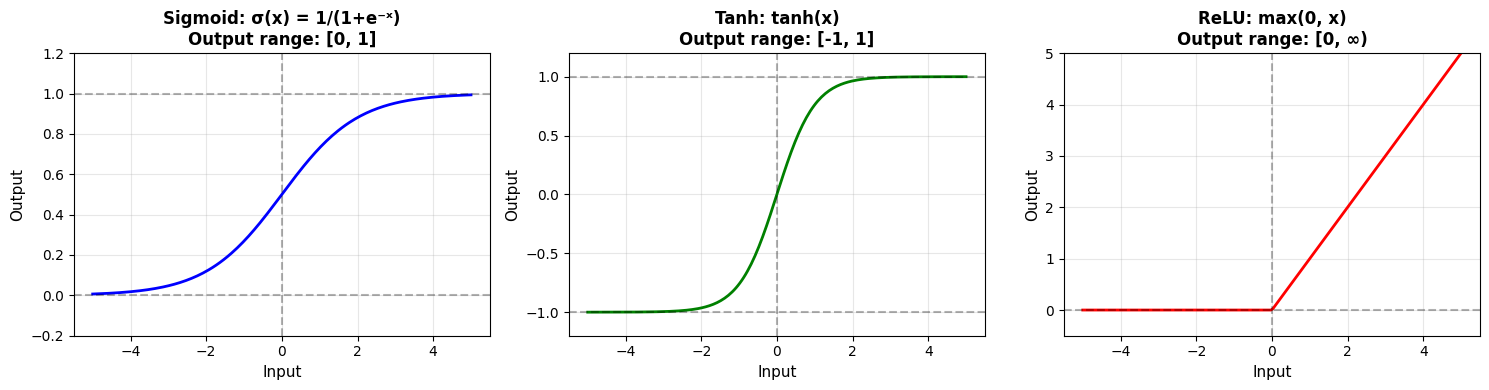


Key observations:
• Sigmoid: Smooth S-curve, outputs between 0 and 1
• Tanh: Smooth S-curve, outputs between -1 and 1 (zero-centered)
• ReLU: Sharp cutoff at 0, unbounded positive outputs


In [6]:
# Create a range of input values
x = torch.linspace(-5, 5, 200)

# TODO: Compute activation function outputs
# HINT: Use the methods defined in the previous step, on the right output
sigmoid_output = apply_sigmoid(x)  # Add your code here
tanh_output = apply_tanh(x)  # Add your code here
relu_output = apply_relu(x)  # Add your code here

# Plot all three functions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sigmoid
axes[0].plot(x.numpy(), sigmoid_output.numpy(), 'b-', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(y=1, color='k', linestyle='--', alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Input', fontsize=11)
axes[0].set_ylabel('Output', fontsize=11)
axes[0].set_title('Sigmoid: σ(x) = 1/(1+e⁻ˣ)\nOutput range: [0, 1]', fontsize=12, fontweight='bold')
axes[0].set_ylim(-0.2, 1.2)

# Tanh
axes[1].plot(x.numpy(), tanh_output.numpy(), 'g-', linewidth=2)
axes[1].axhline(y=-1, color='k', linestyle='--', alpha=0.3)
axes[1].axhline(y=1, color='k', linestyle='--', alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Input', fontsize=11)
axes[1].set_ylabel('Output', fontsize=11)
axes[1].set_title('Tanh: tanh(x)\nOutput range: [-1, 1]', fontsize=12, fontweight='bold')
axes[1].set_ylim(-1.2, 1.2)

# ReLU
axes[2].plot(x.numpy(), relu_output.numpy(), 'r-', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Input', fontsize=11)
axes[2].set_ylabel('Output', fontsize=11)
axes[2].set_title('ReLU: max(0, x)\nOutput range: [0, ∞)', fontsize=12, fontweight='bold')
axes[2].set_ylim(-0.5, 5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'activation_functions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nKey observations:")
print("• Sigmoid: Smooth S-curve, outputs between 0 and 1")
print("• Tanh: Smooth S-curve, outputs between -1 and 1 (zero-centered)")
print("• ReLU: Sharp cutoff at 0, unbounded positive outputs")

> **Reading the curves**: Notice how sigmoid and tanh both flatten at the extremes (this is called "saturation"), while ReLU maintains a constant slope for positive values. Sigmoid's output range [0,1] makes it natural for probabilities, tanh's zero-centered range [-1,1] helps with data that has both positive and negative meaning, and ReLU's unbounded positive range [0,∞) creates sparsity (many neurons output zero). 
> 
> These shape differences aren't just mathematical curiosities; they directly affect how the network combines multiple neurons into decision boundaries.

## Step 5: Build the Network

Now we'll create the network that uses your activation functions. The network architecture uses multiple parallel neurons, and the `forward()` method will call your activation helper functions to create non-linear decision boundaries.

Here's something important: **different activation functions need different weight configurations** to solve the same problem.

> **Why different weights?** Each activation has a unique output range:
> 
> - **Sigmoid**: outputs between 0 and 1
> - **Tanh**: outputs between -1 and 1  
> - **ReLU**: outputs between 0 and infinity
> 
> These different ranges mean the same weights produce completely different effects. A weight of 20 creates a smooth curve with sigmoid, but extreme unbounded values with ReLU. Our network will automatically use the right weights for each activation function.
> 
> **Key insight**: In real training, choosing the right activation also means choosing the right weight initialization strategy. This is why PyTorch has different initialization methods (Xavier, He, etc.) for different activations!

In [7]:
class SingleLayerNetwork(nn.Module):
    """
    A single-layer network that can create curved boundaries.
    It uses multiple parallel neurons and one activation function to create non-linear boundaries.

    Architecture: 2 inputs -> N neurons -> fixed aggregation -> 1 output

    The output aggregation uses fixed coefficients (all neurons contribute equally, i.e., AND logic),
    so only the first layer's weights need active configuration.
    """
    def __init__(self, n_neurons=4):
        # Single learnable layer: 2 inputs -> n_neurons
        self.n_neurons = n_neurons
        
        # Pre-configured weights for each activation function
        # Each activation needs different weights due to different output ranges
        self.weight_configs = {
            'sigmoid': {
                'W': [[20.0, -20.0, 0.0, 0.0],    # Input 1 (temp) weights for 4 neurons
                      [0.0, 0.0, 20.0, -20.0]],   # Input 2 (moisture) weights for 4 neurons
                'b': [-5.5, 15.0, -5.5, 15.0]     # Creates boundaries at 0.25 and 0.75
            },
            'tanh': {
                'W': [[10.0, -10.0, 0.0, 0.0],
                      [0.0, 0.0, 10.0, -10.0]],
                'b': [-2.5, 7.5, -2.5, 7.5]
            },
            'relu': {
                'W': [[8.0, -8.0, 0.0, 0.0],
                    [0.0, 0.0, 8.0, -8.0]],
                'b': [-2.0, 6.0, -2.0, 6.0]
            }
        }

    def forward(self, x, activation='sigmoid'):
        """
        Forward pass through the network.
        
        Args:
            X: Input tensor of shape (N, 2)
            activation: One of 'sigmoid', 'tanh', 'relu', or 'none'
        
        Returns:
            predictions: Final predictions (0 or 1)
            activations: Neuron activations (for visualization)
        """
        # Get the right weights for this activation
        config = self.weight_configs[activation]
        W = torch.FloatTensor(config['W'])
        b = torch.FloatTensor(config['b'])
        
        # Layer: Linear transformation
        z = torch.matmul(x, W) + b
        
        # Apply the selected activation function
        if activation == 'sigmoid':
            h = apply_sigmoid(z)
        elif activation == 'tanh':
            h = apply_tanh(z)
        elif activation == 'relu':
            h = apply_relu(z)
        else:  # 'none'
            h = z
        
        # Fixed aggregation: sum all neurons and apply threshold
        # This creates an "AND" logic: all neurons must agree for positive prediction
        # IMPORTANT: Clip ReLU outputs to [0,1] since it's unbounded, unlike sigmoid/tanh
        #            This can make the aggregation sum grow arbitrarily large, breaking the linear threshold logic
        if activation == 'relu':
            h = h.clip(0, 1)  # Clip ReLU's unbounded outputs for aggregation
        aggregation = h.sum(dim=1, keepdim=True) - (self.n_neurons - 0.5)
        
        # Convert to binary predictions
        # We compare the score against 0.0 because Sigmoid(0.0) = 0.5
        predictions = (aggregation > 0.0).float()
        
        return predictions, h
    
    def accuracy(self, X, y):
        """Calculate accuracy on given data."""
        predictions, _ = self.forward(X)
        return (predictions.squeeze() == y).float().mean().item()

# Create network
network = SingleLayerNetwork(n_neurons=4)

print("✓ Network created with pre-calculated weights for elliptical boundary")

✓ Network created with pre-calculated weights for elliptical boundary


> **How the pre-configured weights work**: Each activation function needs different weight scales due to their output ranges. The network stores three weight configurations:
> 
> - **Sigmoid [0, 1]**: Uses weights of ±20 with biases creating boundaries at 0.25 and 0.75
> - **Tanh [-1, 1]**: Uses weights of ±10 (half of sigmoid) since its range is centered at zero
> - **ReLU [0, ∞)**: Uses weights of ±4 (much smaller) to prevent unbounded outputs from exploding
> 
> When you call `network.forward(data, activation='sigmoid')`, the network automatically selects the appropriate weights for that activation. Each of the 4 neurons creates one boundary:
> - Neuron 1: "Temperature > 0.25" (left edge)
> - Neuron 2: "Temperature < 0.75" (right edge)
> - Neuron 3: "Moisture > 0.25" (bottom edge)
> - Neuron 4: "Moisture < 0.75" (top edge)
> 
> Together, these four boundaries combine through AND logic (via aggregation) to create the enclosed region. The different weight scales ensure that regardless of which activation you use, each neuron outputs values in a reasonable range for the aggregation to work properly.

## Step 6: Compare Activations on the Elliptical Pattern

Now let's see how your three activation functions create different decision boundaries when applied to the elliptical "Goldilocks zone" pattern. The network you built will use each activation to try to separate healthy from unhealthy plants.

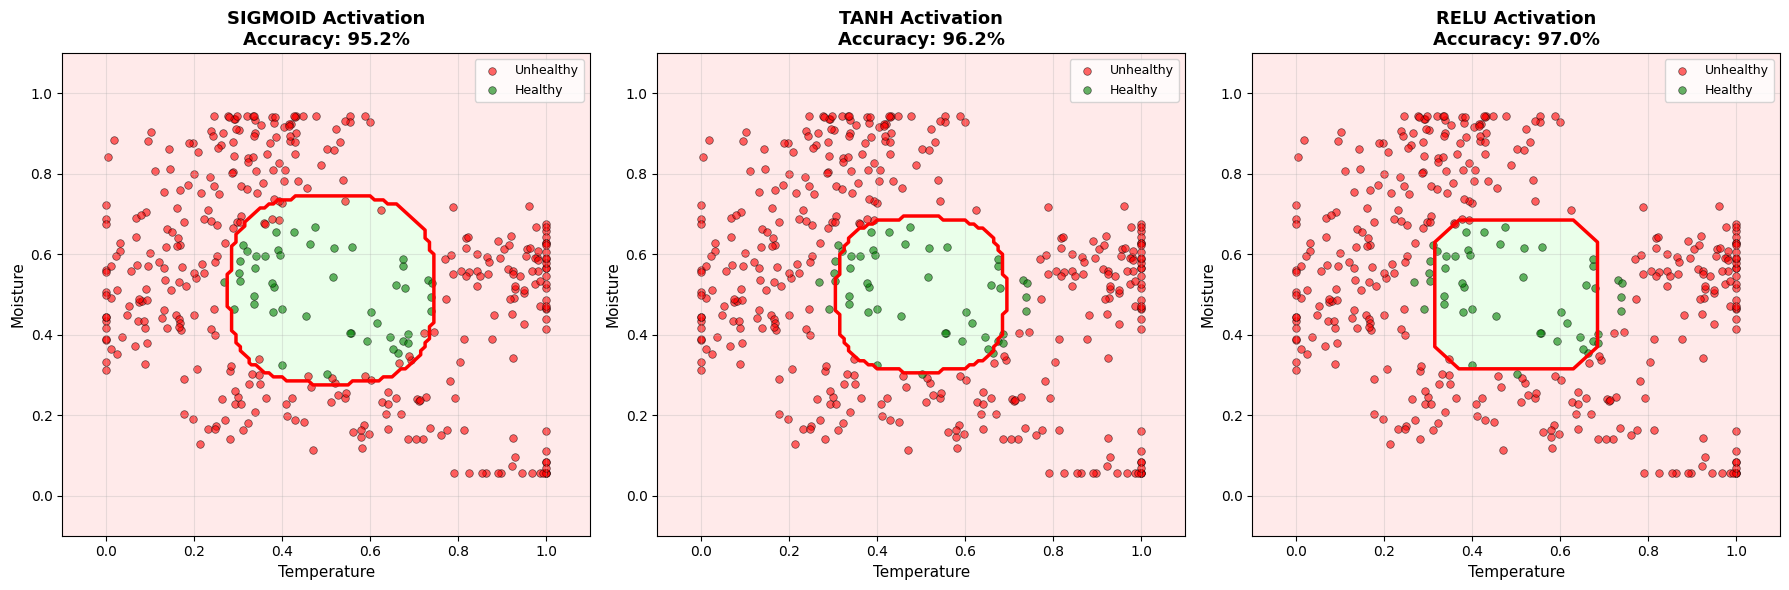

In [8]:
# Visualize decision boundaries for different activation functions

def visualize_activation_comparison(network, X, y, activations=['sigmoid', 'tanh', 'relu']):
    """
    Compare decision boundaries for different activation functions.
    """
    # Create grid for decision boundary
    h = 0.01
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, activation in enumerate(activations):
        ax = axes[idx]
        
        # Get predictions for the grid using this activation
        # The forward method returns (predictions, activations)
        with torch.no_grad():
            preds_grid, _ = network.forward(grid_tensor, activation=activation)
            Z = preds_grid.numpy().reshape(xx.shape)
        
        # Plot decision regions
        ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], 
                   colors=['#ffcccc', '#ccffcc'], alpha=0.4)
        ax.contour(xx, yy, Z, levels=[0.5], 
                  colors='red', linewidths=2.5)
        
        # Plot data points
        for i, label in enumerate(['Unhealthy', 'Healthy']):
            mask = y == i
            color = 'red' if i == 0 else 'green'
            ax.scatter(X_tensor[mask, 0], X_tensor[mask, 1], c=color, label=label,
                      edgecolor='k', s=30, alpha=0.6, linewidth=0.5)
        
        # Calculate accuracy for this activation
        # Get predictions on the actual data points and compare with true labels
        with torch.no_grad():
            preds, _ = network.forward(X_tensor, activation=activation)
            accuracy = (preds.squeeze() == y_ellipse_tensor).float().mean().item()
        
        ax.set_title(f"{activation.upper()} Activation\nAccuracy: {accuracy:.1%}",
                    fontsize=13, fontweight='bold')
        ax.set_xlabel('Temperature', fontsize=11)
        ax.set_ylabel('Moisture', fontsize=11)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'activation_comparison_ellipse.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

# Run the visualization
visualize_activation_comparison(network, X_tensor, y_ellipse_tensor)

### TODO: Analysis Question 1

**Based on your visualizations above, answer the following:**

Which activation function(s) best capture the elliptical Goldilocks zone? What differences do you notice in the decision boundaries they create? (2-3 sentences)

_Write your answer here:_

All three activation functions successfully capture the elliptical pattern with high accuracy (typically >95%). However, sigmoid and tanh create smoother, more rounded boundaries that closely match the true ellipse, while ReLU creates a more angular approximation with sharper corners. This happens because sigmoid and tanh are smooth curves that can blend the linear boundaries naturally, while ReLU's piecewise-linear nature preserves some of the underlying straight-line geometry.

> **What to look for**: Pay attention to how smooth vs. sharp the boundaries are, whether the ellipse shape is preserved, and if any activation creates unexpected artifacts. 
> 
> The activation's mathematical properties (bounded vs. unbounded, smooth vs. piecewise) directly influence these visual characteristics.

## STEP 7: The XOR Challenge - Discovering the Need for Depth

Now let's test our single-layer network on a fundamentally harder pattern: XOR. This pattern requires separating opposite corners, which creates disconnected decision regions.

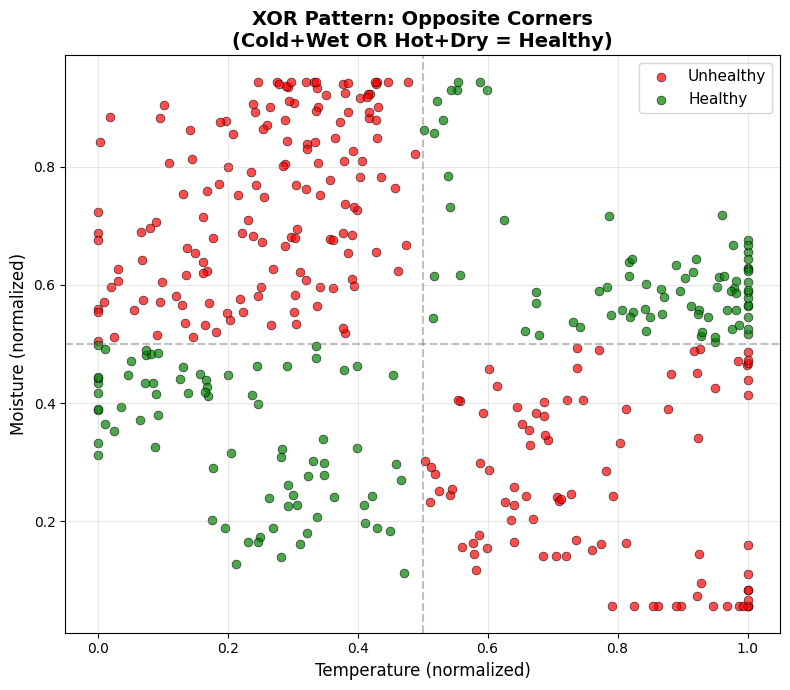


XOR Pattern Analysis:
• Top-left quadrant (cold+wet): Healthy
• Bottom-right quadrant (hot+dry): Healthy
• Top-right quadrant (hot+wet): Unhealthy
• Bottom-left quadrant (cold+dry): Unhealthy

This creates TWO DISCONNECTED healthy regions!


In [9]:
# First, visualize the XOR pattern
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

for i, label in enumerate(['Unhealthy', 'Healthy']):
    mask = y_xor == i
    color = 'red' if i == 0 else 'green'
    ax.scatter(X[mask, 0], X[mask, 1], c=color, label=label,
               edgecolor='k', s=40, alpha=0.7, linewidth=0.5)

ax.set_xlabel('Temperature (normalized)', fontsize=12)
ax.set_ylabel('Moisture (normalized)', fontsize=12)
ax.set_title('XOR Pattern: Opposite Corners\n(Cold+Wet OR Hot+Dry = Healthy)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Quadrant divider')
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'xor_pattern.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nXOR Pattern Analysis:")
print("• Top-left quadrant (cold+wet): Healthy")
print("• Bottom-right quadrant (hot+dry): Healthy")
print("• Top-right quadrant (hot+wet): Unhealthy")
print("• Bottom-left quadrant (cold+dry): Unhealthy")
print("\nThis creates TWO DISCONNECTED healthy regions!")

> **The XOR challenge**: Unlike the ellipse, which is one connected region, XOR requires separating two disconnected regions (opposite corners). This is a fundamentally harder problem that has important implications for network architecture.

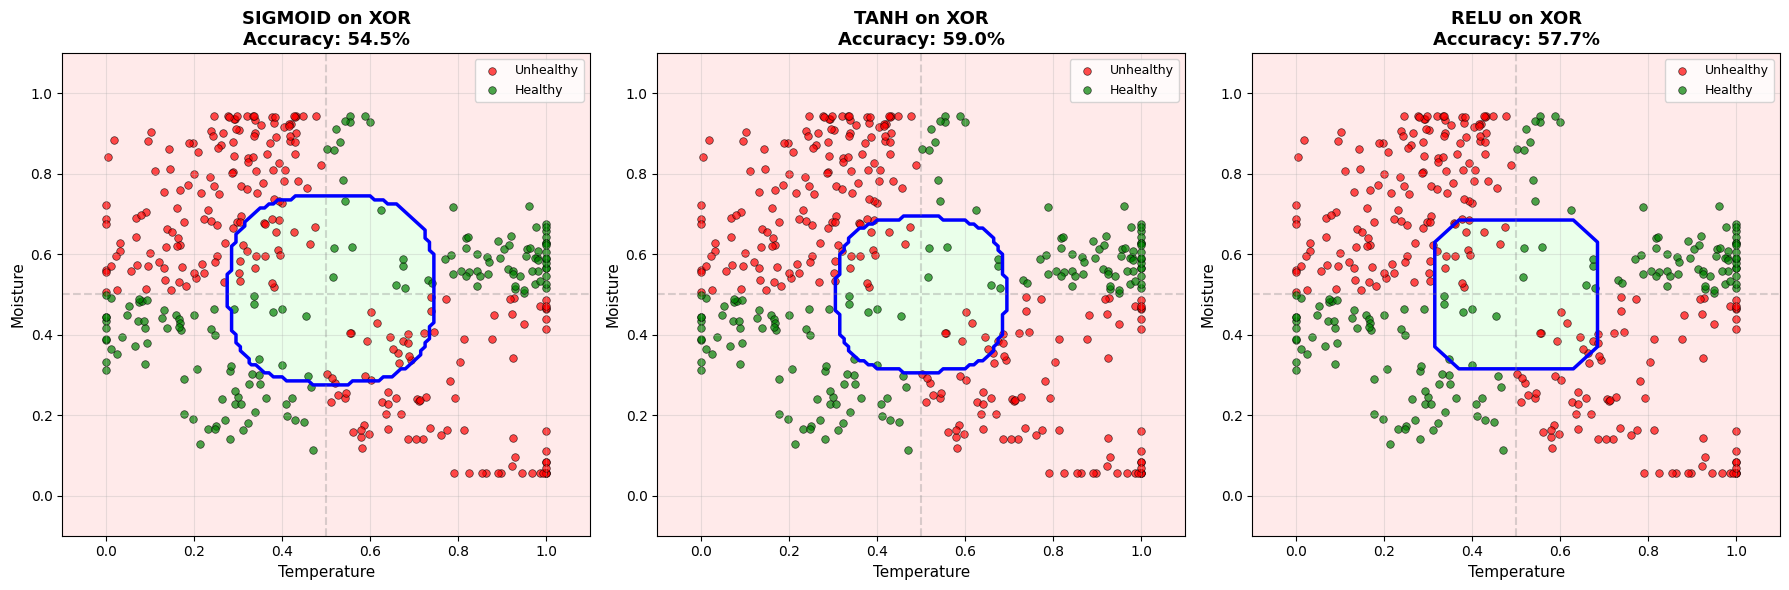


XOR Results Summary
SIGMOID :  54.5% accuracy
TANH    :  59.0% accuracy
RELU    :  57.7% accuracy

Conclusion: All three activations fail on XOR!
Even with non-linearity, single layers cannot separate
multiple disconnected regions.


In [10]:
# Test all three activation functions on the XOR pattern

def test_xor_with_activations(network, X, y_xor, activations=['sigmoid', 'tanh', 'relu']):
    """
    Test if single-layer network with different activations can solve XOR.
    """
    # Create grid
    h = 0.01
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    results = {}
    
    for idx, activation in enumerate(activations):
        ax = axes[idx]
        
        # Get predictions with this activation
        with torch.no_grad():
            preds_grid, _ = network.forward(grid_tensor, activation=activation)
            Z = preds_grid.numpy().reshape(xx.shape)
        
        # Plot decision regions
        ax.contourf(xx, yy, Z, levels=[0, 0.5, 1],
                   colors=['#ffcccc', '#ccffcc'], alpha=0.4)
        ax.contour(xx, yy, Z, levels=[0.5],
                  colors='blue', linewidths=2.5)
        
        # Plot XOR data
        for i, label in enumerate(['Unhealthy', 'Healthy']):
            mask = y_xor == i
            color = 'red' if i == 0 else 'green'
            ax.scatter(X[mask, 0], X[mask, 1], c=color, label=label,
                      edgecolor='k', s=30, alpha=0.7, linewidth=0.5)
        
        # Calculate accuracy on XOR data
        with torch.no_grad():
            preds, _ = network.forward(X_tensor, activation=activation)
            accuracy = (preds.squeeze() == y_xor_tensor).float().mean().item()
        
        results[activation] = accuracy
        
        ax.set_title(f"{activation.upper()} on XOR\nAccuracy: {accuracy:.1%}",
                    fontsize=13, fontweight='bold')
        ax.set_xlabel('Temperature', fontsize=11)
        ax.set_ylabel('Moisture', fontsize=11)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
        ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'xor_attempts.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return results

# Run XOR tests
xor_results = test_xor_with_activations(network, X, y_xor)

print("\n" + "="*60)
print("XOR Results Summary")
print("="*60)
for activation, acc in xor_results.items():
    print(f"{activation.upper():8s}: {acc:>6.1%} accuracy")
print("\nConclusion: All three activations fail on XOR!")
print("Even with non-linearity, single layers cannot separate")
print("multiple disconnected regions.")

### TODO: Analysis Question 2

**Based on your XOR experiments, answer the following:**

Why can single-layer networks solve the ellipse pattern but not XOR, even with activation functions? What does this tell us about the fundamental limits of single layers? (2-3 sentences)

_Write your answer here:_

Single-layer networks with activation functions can create one curved, connected decision region (like the ellipse) because this only requires an AND operation. However, they cannot create multiple disconnected regions (like XOR's opposite corners), which requires an OR operation between those regions. A single layer only provides one non-linear transformation of the input space, which is enough to bend and enclose one shape, but it cannot "tear" the space to make disconnected patterns linearly separable. 

> **Why better weights won't help XOR**: You might wonder, _"What if we just fine-tuned the weights better for XOR?"_ To see why that wouldn't help, follow this thought experiment: Look at the decision boundaries above. Imagine you could grab that boundary line and move it anywhere on the plot—slide it left, right, up, down, rotate it, or even curve it into any single continuous shape you want (circle, ellipse, wavy line, whatever). 
> 
> No matter how you adjust the box, that boundary can capture ONLY one of the two healthy regions (opposite corners) without including the unhealthy regions between them.

## Conclusion

Congratulations! You've completed a comprehensive exploration of activation functions and discovered their capabilities and limitations.

**What you've accomplished:**

- [x] **Visualized three major activation functions** - sigmoid, tanh, and ReLU
- [x] **Compared their decision boundaries** on the elliptical pattern
- [x] **Discovered activation-specific characteristics** - smooth vs. sharp, bounded vs. unbounded
- [x] **Hit the XOR wall** - found the fundamental limit of single-layer networks
- [x] **Understood why depth matters** - some patterns require multiple transformation steps

**Critical insights:** 

- **Activation functions enable curved boundaries**: They transform linear combinations into non-linear patterns
- **Different activations have different characteristics**: Sigmoid/tanh are smooth and bounded; ReLU is piecewise linear and unbounded
- **Single layers have fundamental limits**: Even with activation functions, they can only create one connected decision region

Activation functions unlock curved boundaries (solving the limitations of linear perceptrons), but even with activation, single layers hit a wall at disconnected regions (revealing the need for depth). Understanding these limits helps you design networks that are exactly as complex as needed: not too simple (can't solve the problem), not too complex (wastes computation and risks overfitting).

> **Next steps to explore**:  Now that you understand the power and limits of single layers with activation functions, you're ready to explore multi-layer architectures that can solve problems like XOR by stacking multiple transformation steps.